# Model description
## (this model is still being trained, it should be ready in about 2 hours, I will recommit the new version)

This was the best performing model we found.

It is based on InceptionV3 model pretrained on ImageNet,
we put our own classifier on top, we frozed the weights of the base
and we trained only the top for a few epochs.
Then we thawed all the layers and have been training whole model.

During the first training, this model was reaching 75% accuracy on
a balanced dataset (we trained on equal amount of eyes with and without symptoms for easier assesment).
This model seemed to perform the best on images preprocessed by
Contrast Limited Adaptive Histogram Equalization (CLAHE), to read more about how we preprocessed
our images open [this](https://github.com/rozni/uni-ml/blob/master/Cognitive_Systems_for_Health_Technology_Applications/Case_2/Image_Preprocessing.ipynb) notebook and [here](https://github.com/rozni/uni-ml/tree/master/Cognitive_Systems_for_Health_Technology_Applications/Case_2) is the full report.

We also tried NASNetLarge and MobileNetV2 as our base model,
however, InceptionV3 is a simplier and easier to train model,
so it was faster to reach better results.

In [0]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
import keras
from keras import layers, regularizers
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

Using TensorFlow backend.


In [0]:
BASE_DIR = '/content/'
TRAIN_DIR = '500x500_cropped_clahe_128/'
TARGET_SIZE = (299, 299)

In [0]:
# load the labels and balance the training set
labels_df = pd.read_csv(os.path.join(BASE_DIR, 'labels.csv'))

# balance classes
fifty_fifty_subset = pd.concat([
    labels_df[labels_df['class']=='symptoms'].sample(n=9000, random_state=0),
    labels_df[labels_df['class']=='nosymptoms'].sample(n=9000, random_state=0)
]).sample(frac=1.0, random_state=0) # shuffle

# training/validation split (70% to 30%)
split = 70*len(fifty_fifty_subset)//100
train_df = fifty_fifty_subset.iloc[:split]
valid_df = fifty_fifty_subset.iloc[split:]

In [0]:
# set up image geterators

common_flow_kwargs = dict(
    directory=os.path.join(BASE_DIR, TRAIN_DIR),
    x_col='file_name',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=32,
    class_mode='binary',
)

train_gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=360,
    fill_mode='nearest',
    horizontal_flip=True,
    rescale=1/255,
).flow_from_dataframe(
    dataframe=train_df,
    **common_flow_kwargs,
)

valid_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
).flow_from_dataframe(
    dataframe=valid_df,
    **common_flow_kwargs,
)

Found 12600 images belonging to 2 classes.
Found 5400 images belonging to 2 classes.


In [0]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
# add a classifier
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='elu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(32, activation='elu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(16, activation='elu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

# this is the final model
model = Model(inputs=base_model.input, outputs=output)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# train only the top layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

In [0]:
# train the top of the model
model.fit_generator(
      train_gen,
      steps_per_epoch=train_gen.n//train_gen.batch_size,
      epochs=6,
      validation_data=valid_gen,
      validation_steps=valid_gen.n//valid_gen.batch_size,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/6
393/393 [==============================] - 413s 1s/step - loss: 0.6744 - acc: 0.5953 - val_loss: 0.7152 - val_acc: 0.5240
Epoch 2/6
393/393 [==============================] - 399s 1s/step - loss: 0.6494 - acc: 0.6174 - val_loss: 0.7222 - val_acc: 0.5175
Epoch 3/6
393/393 [==============================] - 397s 1s/step - loss: 0.6443 - acc: 0.6209 - val_loss: 0.7481 - val_acc: 0.5002
Epoch 4/6
393/393 [==============================] - 398s 1s/step - loss: 0.6424 - acc: 0.6236 - val_loss: 0.7310 - val_acc: 0.4961
Epoch 5/6
393/393 [==============================] - 398s 1s/step - loss: 0.6356 - acc: 0.6360 - val_loss: 0.7121 - val_acc: 0.5216
Epoch 6/6
393/393 [==============================] - 397s 1s/step - loss: 0.6368 - acc: 0.6306 - val_loss: 0.7309 - val_acc: 0.4968


In [0]:
# make all layers trainable
for layer in model.layers:
    layer.trainable = True

In [11]:
# setup a model checkpoint (because we have already lost many)
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='Inception-e{epoch:02d}-vl{val_loss:.2f}-va{val_acc:.3f}.hdf5',
    monitor='val_acc',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    period=1
)

# compile again and decrease the learning rate
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001),
    loss='binary_crossentropy',
    metrics=['acc'],
)

# final training
history = model.fit_generator(
      train_gen,
      steps_per_epoch=train_gen.n//train_gen.batch_size,
      epochs=35,
      validation_data=valid_gen,
      validation_steps=valid_gen.n//valid_gen.batch_size,
      callbacks=[checkpoint]
)

Epoch 1/35
393/393 [==============================] - 559s 1s/step - loss: 0.5977 - acc: 0.6675 - val_loss: 0.5645 - val_acc: 0.6945

Epoch 00001: saving model to Inception-e01-vl0.56-va0.694.hdf5
Epoch 2/35
393/393 [==============================] - 525s 1s/step - loss: 0.5563 - acc: 0.7076 - val_loss: 0.5445 - val_acc: 0.7142

Epoch 00002: saving model to Inception-e02-vl0.54-va0.714.hdf5
Epoch 3/35
393/393 [==============================] - 515s 1s/step - loss: 0.5293 - acc: 0.7251 - val_loss: 0.5383 - val_acc: 0.7105

Epoch 00003: saving model to Inception-e03-vl0.54-va0.711.hdf5
Epoch 4/35
393/393 [==============================] - 512s 1s/step - loss: 0.5078 - acc: 0.7405 - val_loss: 0.5926 - val_acc: 0.6863

Epoch 00004: saving model to Inception-e04-vl0.59-va0.686.hdf5
Epoch 5/35
393/393 [==============================] - 513s 1s/step - loss: 0.4911 - acc: 0.7536 - val_loss: 0.5700 - val_acc: 0.6978

Epoch 00005: saving model to Inception-e05-vl0.57-va0.698.hdf5
Epoch 6/35
393/

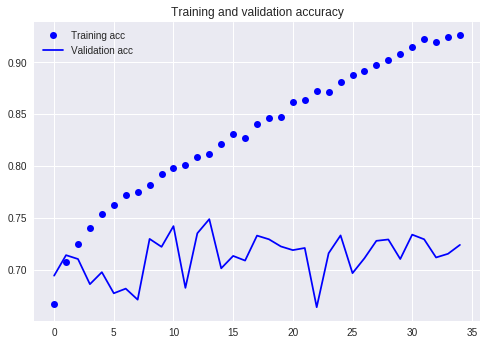

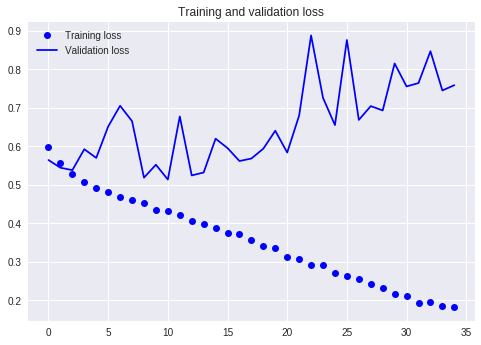

In [14]:
#print statistics
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()